# Previsão de Preços de Frutas e Vegetais com Redes Neurais Recorrentes (RNN)

## Introdução
Neste notebook, iremos utilizar uma Rede Neural Recorrente (RNN) para prever os preços de frutas e vegetais a partir de dados históricos contidos no dataset "Fruits and Vegetables Prices Dataset". O objetivo é demonstrar como podemos aplicar técnicas de deep learning em séries temporais para capturar padrões e tendências nos preços ao longo do tempo.

## Objetivos
- Implementar uma RNN do zero para realizar previsões de preços.
- Explorar e analisar os dados históricos do dataset.
- Avaliar o desempenho do modelo e discutir possíveis melhorias.

## Bibliotecas e Configurações Iniciais
Nesta seção, serão importadas as bibliotecas necessárias (como `pandas`, `numpy`, e um framework de deep learning, por exemplo, PyTorch ou TensorFlow) e realizadas as configurações iniciais, como definição de semente para reprodutibilidade e configuração do ambiente de trabalho.


## Carregamento e Exploração do Dataset
- **Carregamento dos Dados:** Leitura do dataset (por exemplo, de um arquivo CSV) contendo os preços históricos de frutas e vegetais.
- **Exploração Inicial:** Exibição das primeiras linhas, análise de informações gerais (dimensões, tipos de dados, valores ausentes) e visualização de gráficos para entender a evolução dos preços ao longo do tempo.

In [1]:
!pip install mlcroissant

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import mlcroissant as mlc
import pandas as pd
import matplotlib.pyplot as plt

# Fetch the Croissant JSON-LD
croissant_dataset = mlc.Dataset('https://www.kaggle.com/datasets/everydaycodings/produce-prices-dataset/croissant/download')

# Check what record sets are in the dataset
record_sets = croissant_dataset.metadata.record_sets
print(record_sets)

# Fetch the records and put them in a DataFrame
record_set_df = pd.DataFrame(croissant_dataset.records(record_set=record_sets[0].uuid))
record_set_df.head()


/home/esthernunes/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
  -  [Metadata(Fruits and Vegetables Prices Dataset)] Property "http://mlcommons.org/croissant/citeAs" is recommended, but does not exist.


[RecordSet(uuid="ProductPriceIndex.csv")]


,ProductPriceIndex.csv/productname,ProductPriceIndex.csv/date,ProductPriceIndex.csv/farmprice,ProductPriceIndex.csv/atlantaretail,ProductPriceIndex.csv/chicagoretail,ProductPriceIndex.csv/losangelesretail,ProductPriceIndex.csv/newyorkretail,ProductPriceIndex.csv/averagespread
0,b'Strawberries',2019-05-19,b'$1.16',b'$2.23',b'$1.70',b'$1.99',b'$2.54',b'82.33%'
1,b'Romaine Lettuce',2019-05-19,b'$0.35',b'$1.72',b'$2.00',b'$1.69',b'$1.99',b'428.57%'
2,b'Red Leaf Lettuce',2019-05-19,b'$0.32',b'$1.84',b'$1.84',b'$1.69',b'$1.89',b'467.19%'
3,b'Potatoes',2019-05-19,b'$1.50',b'$5.32',b'$5.14',b'$3.99',b'$6.22',b'244.50%'
4,b'Oranges',2019-05-19,b'$0.41',b'$1.42',b'$1.45',b'$1.34',b'$2.05',b'281.71%'


## Pré-processamento dos Dados
- **Tratamento de Datas:** Conversão da coluna de datas para o formato `datetime` e, se necessário, definição da coluna de data como índice.
- **Limpeza dos Dados:** Identificação e tratamento de valores ausentes ou inconsistentes.
- **Normalização:** Escalonamento dos preços para facilitar o treinamento do modelo.
- **Criação de Sequências Temporais:** Transformação dos dados em sequências (por exemplo, utilizando os últimos 30 dias de preços para prever o preço do dia seguinte), garantindo que a ordem temporal seja preservada.

In [3]:
!pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable


In [4]:
!pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable


In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler


df = record_set_df.copy()

columns_mapping = {
    'ProductPriceIndex.csv/productname': 'productname',
    'ProductPriceIndex.csv/date': 'date',
    'ProductPriceIndex.csv/farmprice': 'farmprice',
    'ProductPriceIndex.csv/atlantaretail': 'atlantaretail',
    'ProductPriceIndex.csv/chicagoretail': 'chicagoretail',
    'ProductPriceIndex.csv/losangelesretail': 'losangelesretail',
    'ProductPriceIndex.csv/newyorkretail': 'newyorkretail',
    'ProductPriceIndex.csv/averagespread': 'averagespread'
}
df = df.rename(columns=columns_mapping)

for col in df.columns:
    if df[col].dtype == object:
        if len(df) > 0 and isinstance(df[col].iloc[0], bytes):
            df[col] = df[col].apply(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)

df['date'] = pd.to_datetime(df['date'])
df = df.loc[:, ~df.columns.duplicated()]

In [6]:
# 2. LIMPEZA DOS DADOS
# Remover linhas sem nome de produto
df = df.dropna(subset=['productname'])

# Converter colunas de preço para númerico (remover $ e converter para float)
price_columns = ['farmprice', 'atlantaretail', 'chicagoretail',
                'losangelesretail', 'newyorkretail']

for col in price_columns:
    # Tratar strings vazias e converter para float com tratamento de erros
    df[col] = df[col].replace('', np.nan)  # Substituir strings vazias por NaN
    df[col] = df[col].str.replace('$', '', regex=False)  # Remover $
    df[col] = pd.to_numeric(df[col], errors='coerce')  # Converter para float, forçando erros para NaN

# Verificar valores ausentes nas colunas de preço
missing_values = df[price_columns].isna().sum()
print("Valores ausentes nas colunas de preço:\n", missing_values)

# Preencher valores ausentes com a média da coluna
for col in price_columns:
    df[col] = df[col].fillna(df[col].mean())

# Recalcular a coluna averagespread
df['averagespread'] = ((df[price_columns[1:]].mean(axis=1) / df['farmprice'] - 1) * 100)



Valores ausentes nas colunas de preço:
 farmprice           1
atlantaretail       1
chicagoretail       0
losangelesretail    0
newyorkretail       8
dtype: int64


In [7]:
# 3. NORMALIZAÇÃO
# Criar versão normalizada dos dados para os preços
scaler = MinMaxScaler()
df_normalized = df.copy()
df_normalized[price_columns] = scaler.fit_transform(df[price_columns])

In [8]:
# 4. CRIAÇÃO DE SEQUÊNCIAS TEMPORAIS
# Ordenar por produto e data
df_sorted = df.sort_values(['productname', 'date'])

df_time = df.copy()
df_time.set_index('date', inplace=True)

def create_sequences(data, target_col, sequence_length=30):
    X, y = [], []
    values = data[target_col].values

    for i in range(len(values) - sequence_length):
        X.append(values[i:i+sequence_length])
        y.append(values[i+sequence_length])

    return np.array(X), np.array(y)

# Criar DataFrames individuais por produto
products = df['productname'].unique()
product_dfs = {}

for product in products:
    product_df = df[df['productname'] == product].sort_values('date')
    if len(product_df) > 30:  # Garantir que há dados suficientes para sequências
        product_dfs[product] = product_df

# Exemplos de criação de sequências para alguns produtos
sequence_data = {}
for product, product_df in list(product_dfs.items())[:3]:  # Processar apenas os 3 primeiros produtos
    if len(product_df) > 30:
        X, y = create_sequences(product_df, 'farmprice', sequence_length=30)
        sequence_data[product] = (X, y)
        print(f"Produto: {product}, Formato das sequências: X {X.shape}, y {y.shape}")

df.to_csv('produce_prices_preprocessed.csv', index=False)
df_normalized.to_csv('produce_prices_normalized.csv', index=False)
df_time.to_csv('produce_prices_time_indexed.csv')


Produto: Strawberries, Formato das sequências: X (943, 30), y (943,)
Produto: Romaine Lettuce, Formato das sequências: X (983, 30), y (983,)
Produto: Red Leaf Lettuce, Formato das sequências: X (984, 30), y (984,)


## Definição da Arquitetura da RNN
- **Modelo:** Criação de uma classe para a RNN, definindo:
  - Uma camada recorrente (pode ser uma RNN simples, LSTM ou GRU).
  - Uma camada de saída que gera a previsão do preço.
- **Funcionamento:** Explicação de como a RNN utiliza o histórico de preços para aprender os padrões temporais e realizar as previsões.

In [9]:
# 5. DEFINIÇÃO DA ARQUITETURA DA RNN
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split

EPOCHS = 50
BATCH_SIZE = 32
LEARNING_RATE = 0.001

# Criamos uma classe para a RNN que utiliza uma camada LSTM e uma camada densa na saída
class RNNPricePredictor(Model):
    def __init__(self, units=128):
        super(RNNPricePredictor, self).__init__()
        # Camada recorrente LSTM para capturar os padrões temporais dos preços
        self.lstm = LSTM(units, activation='tanh')
        # Camada de saída que gera a previsão do preço (saída contínua)
        self.dense = Dense(1, activation='linear')
    
    def call(self, inputs):
        # A RNN recebe uma sequência histórica de preços, por exemplo,
        # uma sequência de 30 valores (últimos 30 períodos)
        x = self.lstm(inputs)
        # A camada densa transforma os padrões extraídos em uma previsão de preço
        output = self.dense(x)
        return output
    
product = list(sequence_data.keys())[0]
X, y = sequence_data[product]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

X_train_tensor = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train_tensor = tf.convert_to_tensor(y_train, dtype=tf.float32)
X_val_tensor = tf.convert_to_tensor(X_val, dtype=tf.float32)
y_val_tensor = tf.convert_to_tensor(y_val, dtype=tf.float32)

X_train_tensor = tf.expand_dims(X_train_tensor, axis=-1) 
X_val_tensor = tf.expand_dims(X_val_tensor, axis=-1)

# Instanciando e compilando o modelo
model = RNNPricePredictor(units=128)
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
model.compile(optimizer='adam', loss='mean_squared_error')

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

# Para visualizar a arquitetura do modelo, definimos o formato da entrada:
# Supondo que cada sequência tem 30 passos de tempo e 1 feature (ex.: 'farmprice')
model.build(input_shape=(None, 30, 1))
model.summary()

# Explicação:
# - O modelo RNNPricePredictor é composto por:
#   - Uma camada LSTM que processa a sequência de preços históricos,
#     aprendendo os padrões e relações temporais dos dados.
#   - Uma camada densa que gera a previsão do próximo preço com base nos padrões
#     aprendidos pela LSTM.
#
# - Durante o treinamento, o modelo receberá sequências (por exemplo, os preços dos últimos 30 períodos)
#   e aprenderá a prever o preço do período seguinte. A LSTM é fundamental para capturar dependências
#   temporais, enquanto a camada densa converte essas informações em uma saída numérica contínua.

train_dataset = tf.data.Dataset.from_tensor_slices((X_train_tensor, y_train_tensor))
train_dataset = train_dataset.batch(BATCH_SIZE).shuffle(len(X_train_tensor))

val_dataset = tf.data.Dataset.from_tensor_slices((X_val_tensor, y_val_tensor))
val_dataset = val_dataset.batch(BATCH_SIZE)

history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[early_stopping, reduce_lr]
)


2025-03-22 22:23:34.365247: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-22 22:23:34.388515: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742693014.416098  120586 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742693014.423932  120586 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1742693014.448820  120586 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Model: "rnn_price_predictor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 1.1635 - val_loss: 0.5154 - learning_rate: 0.0010
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.3685 - val_loss: 0.2828 - learning_rate: 0.0010
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.2342 - val_loss: 0.2581 - learning_rate: 0.0010
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.2667 - val_loss: 0.2462 - learning_rate: 0.0010
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.1870 - val_loss: 0.2093 - learning_rate: 0.0010
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.1846 - val_loss: 0.1993 - learning_rate: 0.0010
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.1495 - val_loss: 0.2160 - learning_rate: 0.0010
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.1508 - val_loss: 0.1823 - learning_rate: 0.0010
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.1522 - val_loss: 0.1670 - learning_rate: 0.0010
Epoch 10/50
24/24 ━

## Configuração do Treinamento
- **Preparação dos Dados:** Conversão das sequências e dos valores-alvo em tensores (caso use PyTorch, por exemplo) e criação de DataLoaders para facilitar o processamento em batches.
- **Definição da Função de Perda e Otimizador:** Uso de uma métrica de erro (como o Mean Squared Error - MSE) e escolha de um otimizador (por exemplo, Adam).
- **Configuração de Hiperparâmetros:** Definição do número de épocas, tamanho do batch, taxa de aprendizado, entre outros.

## Treinamento do Modelo
- **Loop de Treinamento:** Processamento dos batches de dados, cálculo da perda, realização do backpropagation e atualização dos pesos.
- **Monitoramento:** Registro e visualização da evolução da perda durante o treinamento para acompanhar o desempenho do modelo.

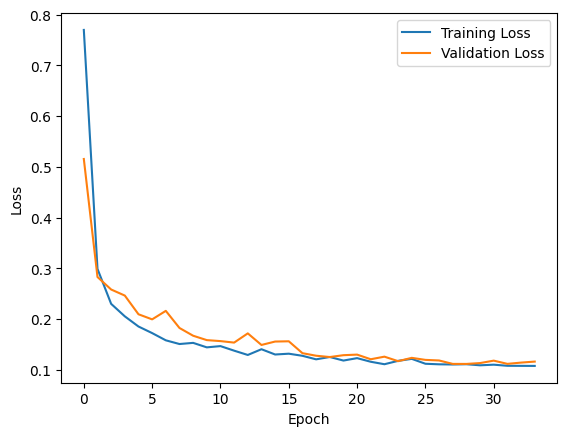

In [10]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Avaliação e Predição
- **Avaliação:** Utilização de um conjunto de teste para avaliar a performance do modelo, comparando as previsões com os valores reais.
- **Visualização dos Resultados:** Criação de gráficos que mostrem as previsões versus os valores reais para identificar se o modelo está capturando os padrões esperados.

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
MAE (Erro Médio Absoluto): 0.23
MSE (Erro Quadrático Médio): 0.12
RMSE (Raiz do Erro Quadrático Médio): 0.34


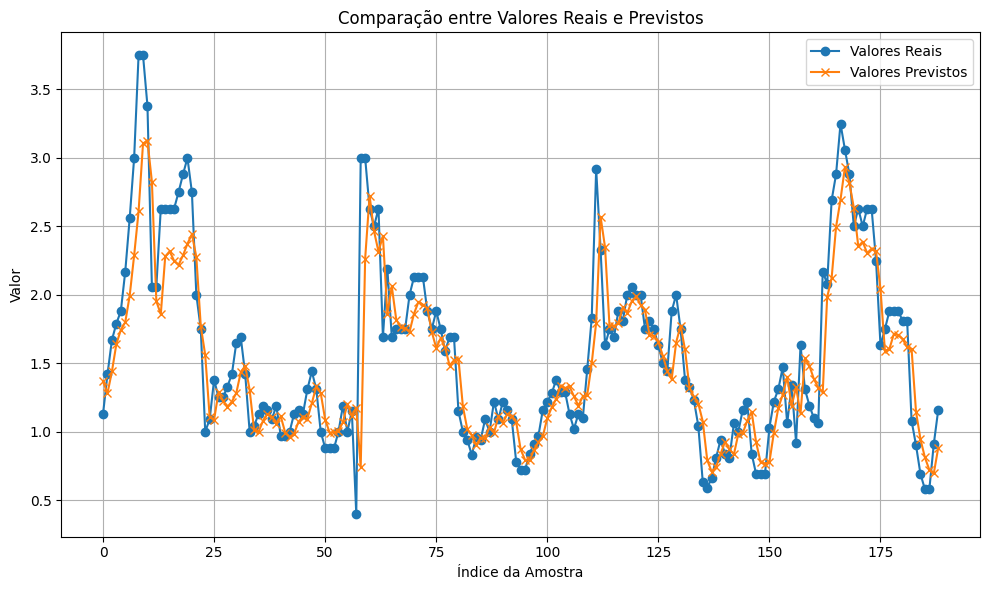

In [ ]:
# 6. AVALIAÇÃO E PREDIÇÃO DO MODELO

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Geração das previsões com o modelo treinado usando o conjunto de validação
y_pred_tensor = model.predict(X_val_tensor)

# Conversão dos tensores para arrays NumPy para facilitar o cálculo das métricas
y_true = y_val_tensor.numpy().flatten()
y_pred = y_pred_tensor.flatten()

# Cálculo das principais métricas de avaliação para problemas de regressão
# - MAE: erro médio absoluto
# - MSE: erro quadrático médio
# - RMSE: raiz do erro quadrático médio (mais interpretável por estar na mesma unidade dos dados)
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)

# Impressão dos valores das métricas
print(f"MAE (Erro Médio Absoluto): {mae:.2f}")
print(f"MSE (Erro Quadrático Médio): {mse:.2f}")
print(f"RMSE (Raiz do Erro Quadrático Médio): {rmse:.2f}")

# Visualização gráfica: comparação entre os valores reais e os valores previstos pelo modelo
plt.figure(figsize=(10, 6))
plt.plot(y_true, label='Valores Reais', marker='o')
plt.plot(y_pred, label='Valores Previstos', marker='x')
plt.title('Comparação entre Valores Reais e Previstos')
plt.xlabel('Índice da Amostra')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Conclusões e Próximos Passos
- **Resumo dos Resultados:** Discussão sobre o desempenho do modelo e os principais aprendizados obtidos durante o projeto.
- **Limitações e Melhorias:** Identificação das limitações atuais e sugestões de possíveis melhorias, como ajuste de hiperparâmetros ou experimentação com arquiteturas mais avançadas (por exemplo, LSTM ou GRU).
- **Perspectivas Futuras:** Ideias para expandir o projeto, aplicando a metodologia a outros datasets ou integrando novas fontes de dados.